In [6]:
pip uninstall elpigraph-python -y

Found existing installation: elpigraph-python 0.1.0
Uninstalling elpigraph-python-0.1.0:
  Successfully uninstalled elpigraph-python-0.1.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import elpigraph

X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
X = np.concatenate(([[0,-1]],X))
pseudotime = np.array([np.linalg.norm(X[0]-x) for x in X])
nnodes=40
%time pg = elpigraph.computeElasticPrincipalTree(X,nnodes)[0]
%time spg = elpigraph.computeElasticPrincipalTree(X,nnodes,FixNodesAtPoints=[[0]],pseudotime=pseudotime,pseudotimeLambda=.1,StoreGraphEvolution=True)[0]
elpigraph.plot.PlotPG(X,pg,Do_PCA=0,X_color=pseudotime)
elpigraph.plot.PlotPG(X,spg,Do_PCA=0,X_color=pseudotime)

CPU times: user 45.5 s, sys: 40.8 s, total: 1min 26s
Wall time: 7.89 s
CPU times: user 3min 10s, sys: 2min 44s, total: 5min 55s
Wall time: 31.4 s


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [8]:
def plot(spg,k):
    MergedNodePositions = spg['AllMergedNodePositions'][k]
    MeanPseudotime = spg['AllMeanPseudotime'][k]
    PseudotimeNodePositions = MergedNodePositions[:int(len(MergedNodePositions)/2)]
    NewNodePositions = MergedNodePositions[int(len(MergedNodePositions)/2):]
    MergedEdges = elpigraph.src.core.DecodeElasticMatrix2(spg['AllMergedElasticMatrices'][k])[0]
    LinkEdges = MergedEdges[:int(len(MergedNodePositions)/2)]
    Edges = MergedEdges[int(len(MergedNodePositions)/2):]-int(len(MergedNodePositions)/2)

    #-----plot
    ax = plt.subplot()
    PlotLinkEdges = LinkEdges.T
    for j in range(PlotLinkEdges.shape[1]):
        x_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [0]], NewNodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [0]]))
        y_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [1]], NewNodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [1]]))
        ax.plot(x_coo, y_coo, c='r', linewidth=1, alpha=0.6)

    PlotEdges=Edges.T
    for j in range(PlotEdges.shape[1]):
        x_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [0]], NewNodePositions[PlotEdges[1, j], [0]]))
        y_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [1]], NewNodePositions[PlotEdges[1, j], [1]]))
        ax.plot(x_coo, y_coo, c="k", linewidth=1, alpha=0.6)

    ax.scatter(*X.T,c=pseudotime,alpha=.05)
    ax.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
    ax.scatter(*NewNodePositions.T,c='k',s=24)
    plt.title(f'{k} nodes')
    plt.show()
def animate(spg,nnodes=6): 
    for k in range(nnodes,len(spg['AllMergedNodePositions'])):
        yield plot(spg,k)
anim=animate(spg)

In [30]:
next(anim)

StopIteration: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import elpigraph


X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
pg = elpigraph.computeElasticPrincipalTree(X,10)[0]
elpigraph.plot.PlotPG(X,pg,Do_PCA=0)
pg = elpigraph.computeElasticPrincipalTree(X,10,FixNodesAtPoints=[list(np.arange(35))])[0]
elpigraph.plot.PlotPG(X,pg,Do_PCA=0)

NameError: name 'pseudotime' is not defined

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import elpigraph

X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
X = np.concatenate(([[1.2,0],
                     [1,1],
                     [0,1]],
                    X))
#X = np.concatenate((np.zeros(25)[None],np.linspace(-1,1,25)[None]),axis=0).T

PointWeights=np.ones(len(X))[None].T
NodePositions=np.array([[-1, 0],
                        [0, -1],
                        [1, 1],
                        [1, .5]])
Edges = np.array([[0,1],
                  [1,2],
                  [2,3]])

SquaredX=np.sum(X**2,axis=1,keepdims=1)
FixNodesAtPoints=[[0, 1, 2, 3, 4, 5],[-1,-2,-3,-4,-5]]
#FixNodesAtPoints=[np.arange(20)]
flat_FixNodesAtPoints = [item for sublist in FixNodesAtPoints for item in sublist] #fixed datapoints
if len(set(flat_FixNodesAtPoints)) != len(flat_FixNodesAtPoints):
    raise ValueError('FixNodesAtPoints lists contain duplicate points')
    
FixedNodePositions = np.array([X[inds].mean(axis=0) for inds in FixNodesAtPoints]) #init fixed nodes 
NodePositions=np.concatenate((FixedNodePositions,NodePositions))

Edges = np.concatenate(([[0,1],[1,2]],Edges+len(FixNodesAtPoints)))
SpringLaplacianMatrix = elpigraph.src.core.MakeUniformElasticMatrix(Edges,.1,.1)

In [24]:
partition, dists = elpigraph.src.core.PartitionData(X,NodePositions,SquaredX=SquaredX,MaxBlockSize=1000000)

# Local data is the data that does not belong to the fixed nodes
# LocalInds is logical index with value true for data points which
# does not correspond to complement of selected set of nodes
# NodeSubSet.
# NodeSubSet is array with numbers of nodes to position optimisation.

#-----Index data and graph into moving nodes and fixed nodes------#
#set of points to fit or keep fixed
flat_FixNodesAtPoints = [item for sublist in FixNodesAtPoints for item in sublist] #fixed datapoints
move_data_idx = [i for i in range(len(X)) if i not in flat_FixNodesAtPoints]
move_nodes_idx = np.arange(len(FixNodesAtPoints),len(NodePositions))
fixed_nodes_idx = np.arange(len(FixNodesAtPoints))
#extract corresponding part of arrays
move_X, move_PointWeights, move_SquaredX, move_NodePositions = X[move_data_idx,:], PointWeights[move_data_idx], SquaredX[move_data_idx], NodePositions[move_nodes_idx]
move_nPoints = len(move_data_idx)
move_partition, move_dists = elpigraph.src.core.PartitionData(move_X,move_NodePositions,SquaredX=move_SquaredX,MaxBlockSize=1000000)
#------Fit-------#

def FitSubGraph2DataGivenPartition(move_X, move_PointWeights, SpringLaplacianMatrix, NodePositions, move_partition, move_nodes_idx):
    """
    Fits moving Subpart of the graph to data while constraining some nodes to remain fixed
    """

    #params 
    NumberOfNodes = len(NodePositions)
    NumberOfNodesSubSet = len(move_nodes_idx)
    NumberOfFixedNodes = NumberOfNodes-NumberOfNodesSubSet
    #new node positions
    NewNodePositions = np.zeros(NodePositions.shape)
    
    #weighted average of moving nodes
    move_NodeClusterCenters, move_NodeClusterRelativeSize = elpigraph.src.core.ComputeWeightedAverage(
        move_X, move_partition, move_PointWeights, NumberOfNodesSubSet
    )

    #SLAUMatrices
    rs = np.zeros((NumberOfNodes))
    rs[move_nodes_idx] = move_NodeClusterRelativeSize.flatten()
    SLAUMatrix  = np.diag(rs)+SpringLaplacianMatrix   
    move_SLAUMatrix = SLAUMatrix[move_nodes_idx][:,move_nodes_idx]
    fixed_SLAUMatrix = SLAUMatrix[move_nodes_idx][:,fixed_nodes_idx]

    #Fit
    RightHandSide = move_NodeClusterRelativeSize * move_NodeClusterCenters
    rhs1 = NodePositions[fixed_nodes_idx]
    RightHandSide -= np.dot(fixed_SLAUMatrix, rhs1)
    move_NewNodePositions = np.linalg.solve(move_SLAUMatrix, RightHandSide)
    
    #Store
    NewNodePositions[fixed_nodes_idx, :] = NodePositions[fixed_nodes_idx, :]
    NewNodePositions[move_nodes_idx, :] = move_NewNodePositions
    
    return NewNodePositions

FitSubGraph2DataGivenPartition(move_X, move_PointWeights, SpringLaplacianMatrix, NodePositions, move_partition, move_nodes_idx)

elpigraph.plot.PlotPG(X,Do_PCA=0)

(array([[-0.26859797,  0.82385726],
        [ 1.16464432,  0.76838245],
        [-1.        ,  0.        ],
        [ 0.        , -1.        ],
        [ 1.        ,  1.        ],
        [ 1.        ,  0.5       ]]),
 array([[-0.26859797,  0.82385726],
        [ 1.16464432,  0.76838245],
        [-0.78628375,  0.25450212],
        [ 0.19098865, -0.62105184],
        [-0.3040868 ,  0.78462493],
        [ 0.6489423 , -0.08047602]]))

# Pseudotime nodes trick
- Small edge between fixed nodes and normal nodes ?

Next things to do
- Modify PartitionData to optimize assignment like barycentric k-means ?
- How to take into account velocity information
- How to deal with categorical labels

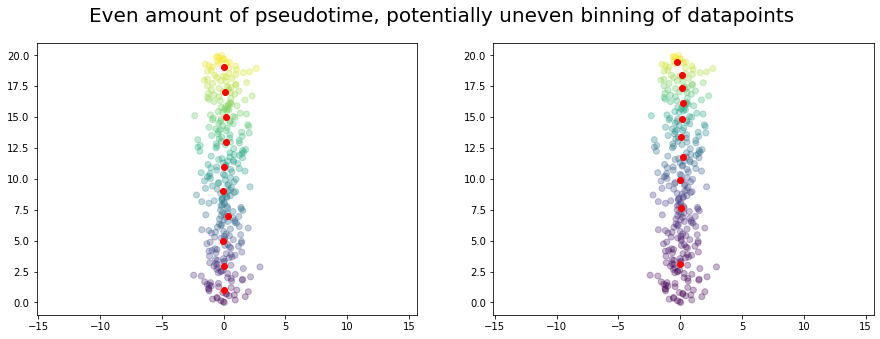

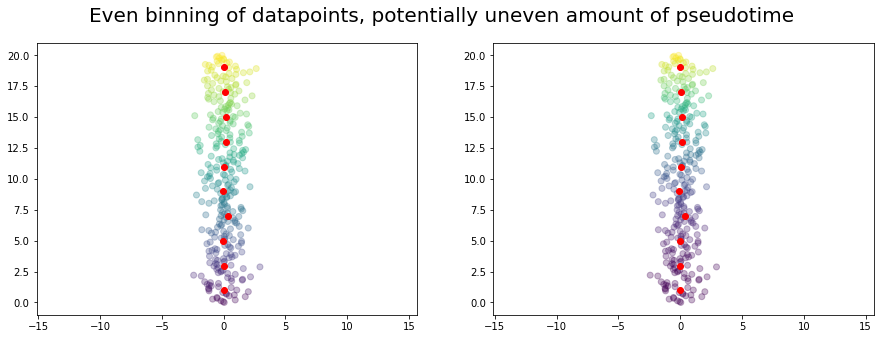

In [13]:
n=300
nnodes = 10
X=np.concatenate(
    (
    np.random.normal(size=(n))[:,None],
    np.linspace(0,20,n)[:,None]
    ),axis=1)
pseudotime0=X[:,1]
pseudotime1=X[:,1]**2

for i in range(2):
    f,ax = plt.subplots(1,2,figsize=(15,5))
    if i==0:
        plt.suptitle('Even amount of pseudotime, potentially uneven binning of datapoints',fontsize=20)
        nodesp0, _ = elpigraph.src.supervised.bin_pseudotime(X,pseudotime0,nnodes)
        nodesp1, _ = elpigraph.src.supervised.bin_pseudotime(X,pseudotime1,nnodes)
    else:
        plt.suptitle('Even binning of datapoints, potentially uneven amount of pseudotime',fontsize=20)
        nodesp0, _ = elpigraph.src.supervised.nNodes_pseudotime(X,pseudotime0,nnodes)
        nodesp1, _ = elpigraph.src.supervised.nNodes_pseudotime(X,pseudotime1,nnodes)

    ax[0].scatter(*X.T,alpha=.3,c=pseudotime0)
    ax[0].scatter(*nodesp0.T,c='r');ax[0].axis('equal')
    ax[1].scatter(*X.T,alpha=.3,c=pseudotime1)
    ax[1].scatter(*nodesp1.T,c='r');ax[1].axis('equal')
    plt.show()

## Single branch version

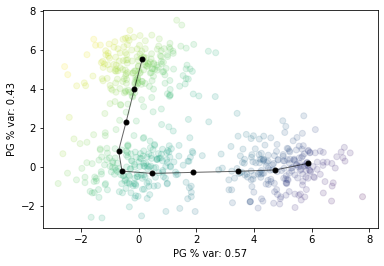

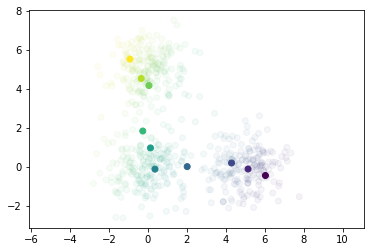

reorienting


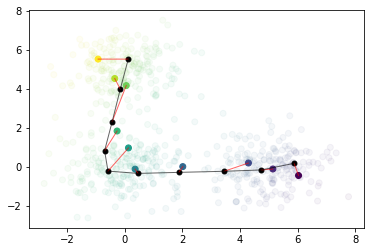

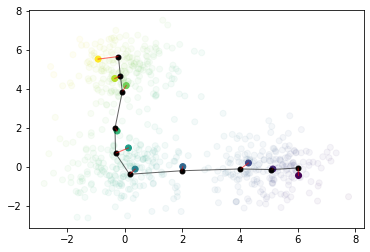

In [23]:
import stream as st
import networkx as nx
import igraph

#-------generate data
n=200
for i,coo in enumerate([(0,0),(5,0),(0,5)]):
    if i==0: X=np.random.normal(coo,size=(n,2))
    else: X=np.concatenate((X,np.random.normal(coo,size=(n,2))))

#-------data labels, pseudotime
color=np.zeros(len(X),dtype=int)
for i in range(0,len(X),n):
    color[i:i+n]=i/n
pseudotime = X[:,1]-X[:,0]*2

#------compute example elpigraph curve (corresponding to elpigraph branch)
pg=elpigraph.computeElasticPrincipalCurve(X,10)[0]
NodePositions = pg['NodePositions']
Edges = pg['Edges'][0]  
ElasticMatrix = pg['ElasticMatrix']
elpigraph.plot.PlotPG(X,pg,Do_PCA=0,X_color=pseudotime)

#-------pseudotime centroid curve
def blocksize_pseudotime(X,pseudotime,blocksize = 25):
    argsort_pseudotime = np.argsort(pseudotime)
    PseudotimeNodePositions = np.zeros((int(len(X)/blocksize),X.shape[1]))
    for idx_curve, idx_data in enumerate(np.arange(0,len(X),blocksize)):
        PseudotimeNodePositions[idx_curve] = X[argsort_pseudotime[idx_data:idx_data+blocksize]].mean(axis=0)
    return PseudotimeNodePositions

def nNodes_pseudotime(X,pseudotime, nNodes):
    blocksize = int(len(X)/nNodes)
    argsort_pseudotime = np.argsort(pseudotime)
    PseudotimeNodePositions = np.zeros((nNodes,X.shape[1]))
    for idx_curve, idx_data in enumerate(np.arange(0,len(X),blocksize)):
        PseudotimeNodePositions[idx_curve] = X[argsort_pseudotime[idx_data:idx_data+blocksize]].mean(axis=0)
    return PseudotimeNodePositions

PseudotimeNodePositions = nNodes_pseudotime(X, pseudotime, nNodes=len(NodePositions))

#------plot
plt.scatter(*X.T,c=pseudotime,alpha=.05)
plt.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
plt.axis('equal')
plt.show()

#-----extract branches
def extract_branches(epg):
    #record the original degree(before removing nodes) for each node
    degrees_of_nodes = epg.degree()
    epg_copy = epg.copy()
    dict_branches = dict()
    clusters_to_merge=[]
    while epg_copy.order()>1: #the number of vertices
        leaves=[n for n,d in epg_copy.degree() if d==1]
        nodes_included=list(epg_copy.nodes())
        while leaves:
            leave=leaves.pop()
            nodes_included.remove(leave)
            nodes_to_merge=[leave]
            nodes_to_visit=list(epg_copy.nodes())
            st.core.dfs_from_leaf(epg_copy,leave,degrees_of_nodes,nodes_to_visit,nodes_to_merge)
            clusters_to_merge.append(nodes_to_merge)
            dict_branches[(nodes_to_merge[0],nodes_to_merge[-1])] = {}
            dict_branches[(nodes_to_merge[0],nodes_to_merge[-1])]['nodes'] = nodes_to_merge
            nodes_to_delete = nodes_to_merge[0:len(nodes_to_merge)-1]
            if epg_copy.degree()[nodes_to_merge[-1]] == 1: #avoid the single point
                nodes_to_delete = nodes_to_merge
                leaves = []
            epg_copy.remove_nodes_from(nodes_to_delete)
    #add branch info
    dict_nodes_pos = nx.get_node_attributes(epg,'pos')
    if(dict_nodes_pos != {}):
        for i,(br_key,br_value) in enumerate(dict_branches.items()):
            nodes = br_value['nodes']
            dict_branches[br_key]['id'] = (nodes[0],nodes[-1]) #the direction of nodes for each branch
    return dict_branches
def get_branches(NodePositions,Edges):
    epg=nx.Graph()
    epg.add_nodes_from(range(NodePositions.shape[0]))
    epg.add_edges_from(Edges)
    dict_nodes_pos = {i:x for i,x in enumerate(NodePositions)}
    nx.set_node_attributes(epg,values=dict_nodes_pos,name='pos')
    dict_branches = extract_branches(epg)
    return dict_branches
branches = get_branches(NodePositions,Edges)

#-----orient branches
for k,v in branches.items():
    if k[0]<k[1]: continue
    else: print('reorienting');branches[k]=v['nodes'][::-1]
        
#------for each branch, orient it in the direction of pseudotime, create elastic edges between pseudotime nodes & elpigraph nodes
branch0 = list(branches.values())[0]
#reorient branch if needed
part, dist = elpigraph.src.core.PartitionData(PseudotimeNodePositions,NodePositions[[branch0[0],branch0[-1]]],
                                            10**8,np.sum(PseudotimeNodePositions**2,axis=1,keepdims=1))
if part[0]!=0: branch0=branch0[::-1]
#create linked elastic edges
#PseudotimeNodes = np.arange(Edges.max()+1,Edges.max()+1+len(PseudotimeNodePositions))
#LinkEdges = np.array(list(zip(PseudotimeNodes, branch0)))

PseudotimeNodes = np.arange(len(PseudotimeNodePositions))
LinkEdges = np.array(list(zip(PseudotimeNodes, np.array(branch0)+len(PseudotimeNodePositions))))
LinkMu, LinkLambda = 0.1, 0.1
LinkMus = np.repeat(LinkMu,len(PseudotimeNodePositions))
LinkLambdas = np.repeat(LinkLambda,len(PseudotimeNodePositions))

#-----plot matching
ax = plt.subplot()
PlotLinkEdges = LinkEdges.T#-np.min(LinkEdges[:,0])
for j in range(PlotLinkEdges.shape[1]):
    x_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [0]], NodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [0]]))
    y_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [1]], NodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [1]]))
    ax.plot(x_coo, y_coo, c='r', linewidth=1, alpha=0.6)
    #ax.scatter(x_coo, y_coo, c=['b','r'], linewidth=1, alpha=0.6)
PlotEdges=Edges.T
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((NodePositions[PlotEdges[0, j], [0]], NodePositions[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((NodePositions[PlotEdges[0, j], [1]], NodePositions[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)

ax.scatter(*X.T,c=pseudotime,alpha=.05)
ax.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
ax.scatter(*NodePositions.T,c='k',s=24)
plt.show()

#-----merge pseudotime and elpigraph nodesp, elasticmatrix
Edges, Lambdas, Mus = elpigraph.src.core.DecodeElasticMatrix(ElasticMatrix)
MergedEdges   = np.concatenate((LinkEdges,Edges+len(PseudotimeNodePositions)))
MergedLambdas = np.concatenate((LinkLambdas,Lambdas))
MergedMus     = np.concatenate((LinkMus,Mus))
MergedNodePositions = np.concatenate((PseudotimeNodePositions,NodePositions))
MergedElasticMatrix = elpigraph.src.core.Encode2ElasticMatrix(MergedEdges, MergedLambdas, MergedMus)

(NewNodePositions, ElasticEnergy, 
 partition, dists, 
 MSE, EP, RP )= elpigraph.src.core.PrimitiveElasticGraphEmbedment(X, MergedNodePositions, MergedElasticMatrix, 
                                                                FixNodesAtPoints=[[] for i in range(len(PseudotimeNodePositions))])
NewNodePositions=NewNodePositions[len(PseudotimeNodePositions):]

#-----plot update
ax = plt.subplot()
PlotLinkEdges = LinkEdges.T#-np.min(LinkEdges[:,0])
for j in range(PlotLinkEdges.shape[1]):
    x_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [0]], NewNodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [0]]))
    y_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [1]], NewNodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [1]]))
    ax.plot(x_coo, y_coo, c='r', linewidth=1, alpha=0.6)
    #ax.scatter(x_coo, y_coo, c=['b','r'], linewidth=1, alpha=0.6)
PlotEdges=Edges.T
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [0]], NewNodePositions[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [1]], NewNodePositions[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)

ax.scatter(*X.T,c=pseudotime,alpha=.05)
ax.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
ax.scatter(*NewNodePositions.T,c='k',s=24)
plt.show()

#---------compare without update
#ax = plt.subplot()
#
#(NewNodePositions, ElasticEnergy, 
# partition, dists, 
# MSE, EP, RP )= elpigraph.src.core.PrimitiveElasticGraphEmbedment(X, NodePositions, ElasticMatrix)
#
#PlotEdges=Edges.T
## plot edges
#for j in range(PlotEdges.shape[1]):
#    x_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [0]], NewNodePositions[PlotEdges[1, j], [0]]))
#    y_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [1]], NewNodePositions[PlotEdges[1, j], [1]]))
#    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)
#
#ax.scatter(*X.T,c=pseudotime,alpha=.05)
#ax.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
#ax.scatter(*NewNodePositions.T,c='k',s=24)
#plt.show()

## Tree version

### Choices to bin pseudotime nodes

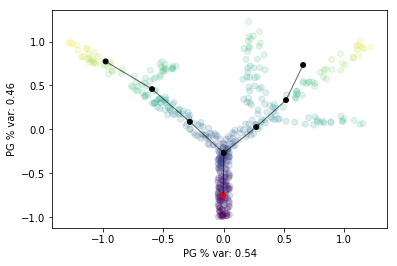

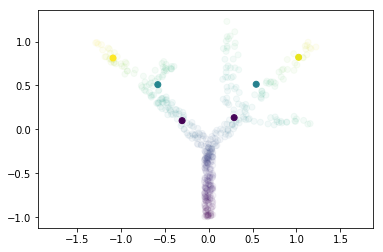

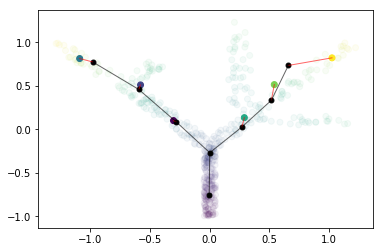

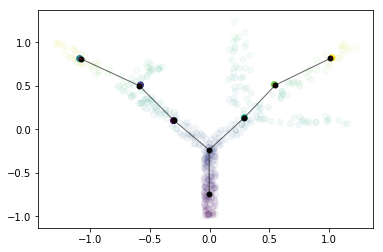

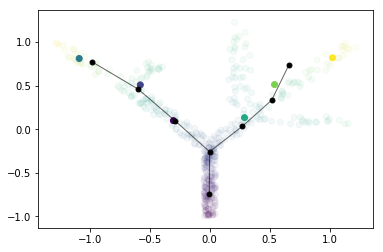

In [62]:
import networkx as nx
import itertools

#-------generate data
X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]

#-------data labels, pseudotime
pseudotime = X[:,1]+np.abs(X[:,0])

#------compute example elpigraph tree
pg=elpigraph.computeElasticPrincipalTree(X,8)[0]
NodePositions = pg['NodePositions']
Edges = pg['Edges'][0]  
ElasticMatrix = pg['ElasticMatrix']
#define root node = node with lowest associated mean pseudotime
part, dist = elpigraph.src.core.PartitionData(X,NodePositions,10**8,np.sum(X**2,axis=1,keepdims=1))
root_node = np.argmin([pseudotime[part.flat==n].mean() for n in np.unique(part)])
elpigraph.plot.PlotPG(X,pg,Do_PCA=0,X_color=pseudotime, Node_color=["r" if i==root_node else "k" for i in range(len(NodePositions))])

#-----extract oriented branches and associated data
def bf_search(dict_branches, root_node):
    ''' breadth-first tree search '''
    flat_tree = nx.Graph()
    flat_tree.add_nodes_from(list(set(itertools.chain.from_iterable(dict_branches.keys()))))
    flat_tree.add_edges_from(dict_branches.keys())
    edges = list(nx.bfs_edges(flat_tree, root_node))
    nodes = [root_node] + [v for u, v in edges]
    return edges, nodes

def get_tree(Edges, root_node):
    ##handle edge case: circle or curve topology
    if np.bincount(Edges.flat).max()==2:
        print('WARNING: fitting circle or curve topology')
        branches_single_end = elpigraph.src.supervised.get_circle_or_curve(Edges, root_node)
        return None, None, branches_single_end
    #----get branches
    net=elpigraph.src.graphs.ConstructGraph({'Edges':[Edges]})
    branches=elpigraph.src.graphs.GetSubGraph(net,'branches')
    _dict_branches = {(b[0],b[-1]) : b for i,b in enumerate(branches)} #temporary branch node lists (not in order)
    
    #----check validity of the root node
    root_branch = [k for k in _dict_branches.keys() if root_node in k]
    if len(root_branch)>1: raise ValueError(f'Multiple root branches {root_branch}')
        
    #----reorder branches
    #find ordered relations between branches
    ordered_edges, ordered_nodes = bf_search(_dict_branches,root_node)

    #----create ordered dicts
    dict_tree = {} #branch parent-child relations
    dict_branches = {} #branch node lists
    dict_branches_single_end = {} #branch node lists with no overlapping terminal nodes
    #visited_nodes = []
    for i, e in enumerate(ordered_edges): #for each branch
        #store branch in order (both the key and the list)
        if e not in _dict_branches: dict_branches[e] = _dict_branches[e[::-1]][::-1]
        else: dict_branches[e] = _dict_branches[e]

        #store children 
        dict_tree[e]=[_e for _e in ordered_edges[:i]+ordered_edges[i+1:] if e[-1] in _e]

        #store single ended branch
        if i==0: dict_branches_single_end[e] = dict_branches[e]#if n not in visited_nodes]
        else: dict_branches_single_end[e] = dict_branches[e][1:]
        #dict_branches_single_end[e] = [n for n in dict_branches[e] if n not in visited_nodes]
        #visited_nodes.extend(dict_branches[e])
    return dict_tree, dict_branches, dict_branches_single_end
    
def partition_data_by_branch(X, NodePositions, branches):
    partition, dists = elpigraph.src.core.PartitionData(X,NodePositions,10**8,np.sum(X**2,axis=1,keepdims=1))
    branches_dataidx = {k : np.isin(partition[:,0],b) for k,b in branches.items()}
    return branches_dataidx



tree, branches, branches_single_end = get_tree(Edges, root_node)
branches_dataidx = partition_data_by_branch(X, NodePositions, branches_single_end)
branches_dataidx[(2,0)]=np.repeat(False,len(X))

#-------pseudotime centroid curve
def nNodes_pseudotime(bX, bpseudotime, bnNodes):
    blocksize = int(len(bX)/bnNodes)
    argsort_pseudotime = np.argsort(pseudotime)
    PseudotimeNodePositions = np.zeros((bnNodes,X.shape[1]))
    for idx_curve, idx_data in enumerate(np.arange(0,len(X),blocksize)):
        PseudotimeNodePositions[idx_curve] = bX[argsort_pseudotime[idx_data:idx_data+blocksize]].mean(axis=0)
    return PseudotimeNodePositions

def bin_pseudotime(bX, bpseudotime, bnNodes):
    #create nodes with uniformly spread pseudotime
    count, bins = np.histogram(bpseudotime,bins=bnNodes)
    clusters = np.digitize(bpseudotime,bins[1:],right=True)
    PseudotimeNodePositions = np.zeros((bnNodes,X.shape[1]))
    MeanPseudotime = np.zeros(bnNodes)
    #for each branch node
    for j in range(bnNodes):
        #index associated data
        data_idx = clusters==j
        #generate node
        PseudotimeNodePositions[j] = bX[data_idx].mean(axis=0)
        MeanPseudotime[j] = bpseudotime[data_idx].mean()
    return PseudotimeNodePositions, MeanPseudotime

def gen_pseudotime_centroids(X, pseudotime, branches_single_end, branches_dataidx):
    '''generate pseudotime centroids for each branch of the graph'''
    
    #ignore branches with no associated data
    nonempty_branches_dataidx = {}
    nonempty_branches_single_end = {}
    nonempty_nNodes = 0
    for (k, bdata), bnodes in zip(branches_dataidx.items(),branches_single_end.values()):
        if len(np.where(bdata)[0])!=0:
            nonempty_branches_dataidx[k] = bdata
            nonempty_branches_single_end[k] = bnodes
            nonempty_nNodes += len(branches_single_end[k]) 
    
    PseudotimeNodePositions = np.zeros((nonempty_nNodes,X.shape[1]))
    MeanPseudotime = np.zeros(nonempty_nNodes)
    
    n = 0
    for i, (k,bdata) in enumerate(nonempty_branches_dataidx.items()): #for data associated with each branch

        #branch data points, pseudotime
        bX, bpseudotime = X[bdata], pseudotime[bdata]
        bnNodes=len(branches_single_end[k])
        
        #generate branch ps node positions
        PseudotimeNodePositions[n:n+bnNodes], MeanPseudotime[n:n+bnNodes] = bin_pseudotime(bX, bpseudotime, bnNodes)
        
        n+=bnNodes
        
    return PseudotimeNodePositions, MeanPseudotime, nonempty_branches_single_end

PseudotimeNodePositions, MeanPseudotime, nonempty_branches_single_end = gen_pseudotime_centroids(X, pseudotime, branches_single_end, branches_dataidx)

#------plot
plt.scatter(*X.T,c=pseudotime,alpha=.05)
plt.scatter(*PseudotimeNodePositions.T,c=MeanPseudotime)
plt.axis('equal')
plt.show()

#------for each branch, create elastic edges between pseudotime nodes & elpigraph nodes
NodesOrder = np.array([n for b in nonempty_branches_single_end.values() for n in b])
PseudotimeNodes = np.arange(len(PseudotimeNodePositions))
LinkEdges = np.array(list(zip( PseudotimeNodes, NodesOrder+len(PseudotimeNodePositions) )))
LinkMu, LinkLambda = 0, .5
LinkMus = np.repeat(LinkMu,len(PseudotimeNodePositions))
LinkLambdas = np.repeat(LinkLambda,len(PseudotimeNodePositions))

#-----plot matching
ax = plt.subplot()
PlotLinkEdges = LinkEdges.T#-np.min(LinkEdges[:,0])
for j in range(PlotLinkEdges.shape[1]):
    x_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [0]], NodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [0]]))
    y_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [1]], NodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [1]]))
    ax.plot(x_coo, y_coo, c='r', linewidth=1, alpha=0.6)
    #ax.scatter(x_coo, y_coo, c=['b','r'], linewidth=1, alpha=0.6)
PlotEdges=Edges.T
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((NodePositions[PlotEdges[0, j], [0]], NodePositions[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((NodePositions[PlotEdges[0, j], [1]], NodePositions[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)

ax.scatter(*X.T,c=pseudotime,alpha=.05)
ax.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
ax.scatter(*NodePositions.T,c='k',s=24)
plt.show()

#-----merge pseudotime and elpigraph nodesp, elasticmatrix

def pseudotime_augmented_graph(NodePositions, Edges, PseudotimeNodePositions, branches_single_end, Mus, Lambdas, LinkMu, LinkLambda):
    '''
    generate a graph merging node positions and pseudotime node positions
    with one edge between each of their nodes. 
    pseudotime node positions and edges are placed as the top rows of the matrices
    '''
    #------for each branch, create elastic edges between pseudotime nodes & elpigraph nodes
    #ordering of nodespositions in the graph (corresponding to pseudotime nodes)
    NodesOrder = np.array([n for b in branches_single_end.values() for n in b])
    PseudotimeNodes = np.arange(len(PseudotimeNodePositions))
    #link pseudotime nodes and graph nodes
    LinkEdges = np.array(list(zip( PseudotimeNodes, NodesOrder+len(PseudotimeNodePositions) )))
    LinkMus = np.repeat(LinkMu,len(PseudotimeNodePositions))
    LinkLambdas = np.repeat(LinkLambda,len(PseudotimeNodePositions))
    
    #-----merge pseudotime and graph nodepositions, elasticmatrix
    MergedNodePositions = np.concatenate((PseudotimeNodePositions,NodePositions))
    MergedEdges   = np.concatenate((LinkEdges,Edges+len(PseudotimeNodePositions)))
    MergedLambdas = np.concatenate((LinkLambdas,Lambdas))
    MergedMus     = np.concatenate((LinkMus,Mus))
    MergedElasticMatrix = elpigraph.src.core.Encode2ElasticMatrix(MergedEdges, MergedLambdas, MergedMus)

    return MergedNodePositions, MergedElasticMatrix, MergedEdges, MergedLambdas, MergedMus
Edges, Lambdas, Mus = elpigraph.src.core.DecodeElasticMatrix(ElasticMatrix)
MergedNodePositions, MergedElasticMatrix, MergedEdges, MergedLambdas, MergedMus = pseudotime_augmented_graph(NodePositions, Edges, PseudotimeNodePositions, 
                                                                                                       nonempty_branches_single_end, Mus, Lambdas, LinkMu, LinkLambda)


(NewNodePositions, ElasticEnergy, 
 partition, dists, 
 MSE, EP, RP )= elpigraph.src.core.PrimitiveElasticGraphEmbedment(X, MergedNodePositions, MergedElasticMatrix, 
                                                                FixNodesAtPoints=[[] for i in range(len(PseudotimeNodePositions))])
NewNodePositions=NewNodePositions[len(PseudotimeNodePositions):]

#-----plot update
ax = plt.subplot()
PlotLinkEdges = LinkEdges.T#-np.min(LinkEdges[:,0])
for j in range(PlotLinkEdges.shape[1]):
    x_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [0]], NewNodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [0]]))
    y_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [1]], NewNodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [1]]))
    ax.plot(x_coo, y_coo, c='r', linewidth=1, alpha=0.6)
    #ax.scatter(x_coo, y_coo, c=['b','r'], linewidth=1, alpha=0.6)
PlotEdges=Edges.T
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [0]], NewNodePositions[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [1]], NewNodePositions[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)

ax.scatter(*X.T,c=pseudotime,alpha=.05)
ax.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
ax.scatter(*NewNodePositions.T,c='k',s=24)
plt.show()

#---------compare without update
ax = plt.subplot()

(NewNodePositions, ElasticEnergy, 
 partition, dists, 
 MSE, EP, RP )= elpigraph.src.core.PrimitiveElasticGraphEmbedment(X, NodePositions, ElasticMatrix,FixNodesAtPoints=[])

PlotEdges=Edges.T
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [0]], NewNodePositions[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [1]], NewNodePositions[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)

ax.scatter(*X.T,c=pseudotime,alpha=.05)
ax.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
ax.scatter(*NewNodePositions.T,c='k',s=24)
plt.show()

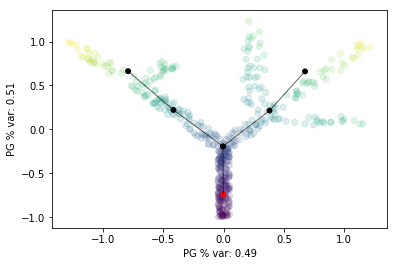

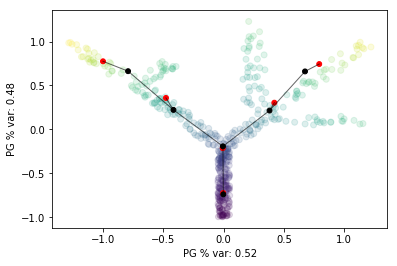

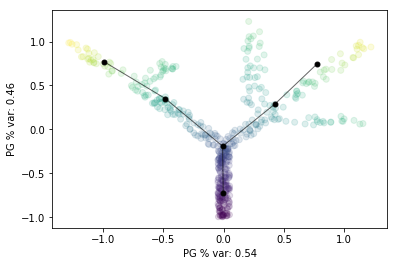

In [10]:
#-------generate data, data labels, pseudotime
X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
pseudotime = X[:,1]+np.abs(X[:,0])

#------compute example elpigraph tree
pg=elpigraph.computeElasticPrincipalTree(X,6)[0]
NodePositions, ElasticMatrix = pg['NodePositions'], pg['ElasticMatrix']
Edges, Lambdas, Mus = elpigraph.src.core.DecodeElasticMatrix(ElasticMatrix)

#------define parameters: root node (node with lowest associated mean pseudotime) and pseudotime edges lambdas, Mus
LinkMu, LinkLambda = 0, .5
part, dist = elpigraph.src.core.PartitionData(X,NodePositions,10**8,np.sum(X**2,axis=1,keepdims=1))
root_node = np.argmin([pseudotime[part.flat==n].mean() for n in np.unique(part)])

#------generate merged graph
MeanPseudotime, MergedNodePositions, MergedElasticMatrix, MergedEdges, nPseudoNodes = elpigraph.src.supervised.gen_pseudotime_augmented_graph(X, np.sum(X**2,axis=1,keepdims=1), NodePositions, ElasticMatrix, pseudotime, root_node, LinkMu, LinkLambda)

#------fit the graph
NewNodePositions, ElasticEnergy, partition, dists, MSE, EP, RP = elpigraph.src.core.PrimitiveElasticGraphEmbedment(X, MergedNodePositions, MergedElasticMatrix, FixNodesAtPoints=[[] for i in range(nPseudoNodes)])
NewNodePositions=NewNodePositions[nPseudoNodes:]

elpigraph.plot.PlotPG(X,pg,Do_PCA=0,X_color=pseudotime, Node_color=["r" if i==root_node else "k" for i in range(len(NodePositions))])
elpigraph.plot.PlotPG(X,{'NodePositions':MergedNodePositions,'Edges':[MergedEdges]},Do_PCA=0,
                      X_color=pseudotime, Node_color=["r" if i<nPseudoNodes else "k" for i in range(len(MergedNodePositions))])
elpigraph.plot.PlotPG(X,{'NodePositions':NewNodePositions,'Edges':[Edges]},Do_PCA=0,X_color=pseudotime)

In [126]:
%load_ext line_profiler
%lprun -f elpigraph.src.supervised.gen_pseudotime_augmented_graph elpigraph.src.supervised.gen_pseudotime_augmented_graph(X, NodePositions, ElasticMatrix, pseudotime, root_node, LinkMu, LinkLambda)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-06 s

Total time: 0.005609 s
File: /mnt/c/Users/jobac/Desktop/all/git/elpigraph-python/elpigraph/src/supervised.py
Function: gen_pseudotime_augmented_graph at line 199

Line #      Hits         Time  Per Hit   % Time  Line Contents
   199                                           def gen_pseudotime_augmented_graph(
   200                                               X, NodePositions, ElasticMatrix, pseudotime, root_node, LinkMu, LinkLambda
   201                                           ):
   202                                               # ------extract oriented branches and associated data
   203         1        343.0    343.0      6.1      Edges, Lambdas, Mus = DecodeElasticMatrix(ElasticMatrix)
   204                                           
   205                                               # handle edge case: circle or curve topology
   206         1         90.0     90.0      1.6      if np.bincount(Edges.flat).max() == 2:
   207                         

In [50]:
import numba as nb
@nb.njit(parallel=True)
def nb_mean_axis0(a):
    res = []
    for i in nb.prange(a.shape[1]):
        res.append(a[:, i].mean())
    return np.array(res)

@nb.njit
def nb_bin_pseudotime(bX, bpseudotime, bnNodes):
    """"
    Argsorts pseudotime and create nNodes bins 
    with even amounts of pseudotime but potentially uneven number of points
    """
    # create nodes with uniformly spread pseudotime
    count, bins = np.histogram(bpseudotime, bins=bnNodes)
    clusters = np.digitize(bpseudotime, bins[1:], right=True)
    PseudotimeNodePositions = np.zeros((bnNodes, bX.shape[1]))
    MeanPseudotime = np.zeros(bnNodes)
    # for each branch node
    for j in range(bnNodes):
        # index associated data
        data_idx = clusters == j
        # generate node
        PseudotimeNodePositions[j] = nb_mean_axis0(bX[data_idx])
        MeanPseudotime[j] = bpseudotime[data_idx].mean()
    return PseudotimeNodePositions, MeanPseudotime